In [ ]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Calculando gradientes quânticos em qualquer dispositivo

Nos dois últimos notebooks, vimos que o PennyLane permite que você "aloque" perfeitamente os cálculos quânticos em estruturas de diferenciação automática. Enquanto usamos a estrutura Numpy/Autograd, você também pode fazer a interface do PennyLane com PyTorch, Tensorflow e Jax.

Se computações quânticas são *simuladas* codificando multiplicações de vetores de matriz em uma linguagem de codificação específica, elas se tornam apenas computações diferenciáveis. Este é o truque que o dispositivo `default.qubit` usa se possível: ele sabe simular circuitos quânticos em Autograd, TensorFlow etc. Mas e se usarmos um dispositivo que não seja implementado de forma automática de diferenciação? E se o dispositivo usar hardware quântico?

No PennyLane, qualquer dispositivo quântico, seja um dispositivo de hardware ou um simulador, pode ser treinado usando a [regra de mudança de parâmetro](https://pennylane.ai/qml/glossary/parameter_shift.html) para calcular gradientes quânticos. De fato, a regra de mudança de parâmetro é ideal para dispositivos de hardware, pois
não requer nenhum conhecimento sobre o funcionamento interno do dispositivo; basta tratar o dispositivo como uma 'caixa preta' e consultá-lo com diferentes valores de entrada para determinar o gradiente.

## 1. A regra de mudança de parâmetro


A regra de mudança de parâmetro afirma que, dado um circuito quântico variacional $U(\boldsymbol
\theta)$ composto de rotações de Pauli parametrizadas, e algumas medidas observáveis ​​$\mathcal{M}$, o
derivada do valor esperado


\begin{align}\langle \mathcal{M} \rangle (\boldsymbol\theta) =
    \langle 0 \vert U(\boldsymbol\theta)^\dagger \mathcal{M} U(\boldsymbol\theta) \vert 0\rangle\end{align}

em relação aos parâmetros do circuito de entrada $\boldsymbol{\theta}$ é dado por

\begin{align}\nabla_{\theta_i}\langle \mathcal{M} \rangle(\boldsymbol\theta)
      = \frac{1}{2}
            \deixei[
                \langle \mathcal{M} \rangle\left(\boldsymbol\theta + \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
              - \langle \mathcal{M} \rangle\left(\boldsymbol\theta - \frac{\pi}{2}\hat{\mathbf{e}}_i\right)
            \direita].\end{alinhar}

Assim, o gradiente do valor esperado pode ser calculado avaliando o mesmo circuito quântico variacional, mas com valores de parâmetro deslocados (daí o nome, regra de deslocamento de parâmetro!).

## 2. Hand-coded parameter-shift rule

Vamos primeiro implementar a regra de mudança de parâmetro manualmente. Usamos o modelo quântico do notebook anterior.

In [ ]:
dev = qml.device("default.qubit", wires=2) 

In [ ]:
@qml.qnode(dev, diff_method='parameter-shift')
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=1))

x = np.array([0.1, 0.2], requires_grad=False)
w = np.array([[-2.1, 1.2], [-1.4, -3.9], [0.5, 0.2]])

quantum_model(x, w)

tensor(-0.0471305, requires_grad=True)

In [ ]:
print(quantum_model.draw())

AttributeError: ignored

Agora que definimos nosso circuito variacional QNode, podemos construir
uma função que calcula o gradiente do parâmetro $i\text{th}$
usando a regra de mudança de parâmetro. Como o modelo também depende da entrada $x$, o gradiente será calculado apenas para este $x$ fixo.


In [ ]:
def parameter_shift_term(qnode, params, x, i, j):
    
    shifted = params.copy()
    
    shifted[i, j] += np.pi/2
    forward = qnode(x, shifted)  # forward evaluation

    shifted[i, j] -= np.pi
    backward = qnode(x, shifted) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(quantum_model, w, x, 0, 0))

-0.6646069909211211


:Para calcular o gradiente em relação a *todos* os parâmetros, precisamos
para percorrer os índices ``i`` e ``j``:

In [ ]:
def parameter_shift(qnode, params, x):
    gradients = np.zeros_like((params))

    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] = parameter_shift_term(qnode, w, x, i, j)

    return gradients

print(parameter_shift(quantum_model, w, x))

[[-6.64606991e-01  5.27491000e-02]
 [ 5.55111512e-17  5.27491000e-02]
 [-6.64606991e-01  5.27491000e-02]]


## 3. Built-in parameter shift differentiation

Podemos comparar isso com o recurso de mudança de parâmetro * embutido * do PennyLane usando
a função `qml.grad`. Lembre-se, quando definimos o
QNode, especificamos que queríamos que fosse diferenciável usando o parâmetro-shift
método (``diff_method="parameter-shift"``).

In [ ]:
grad_function = qml.grad(quantum_model, argnum=1)

print(grad_function(x, w))

[[-6.64606991e-01  5.27491000e-02]
 [ 5.55111512e-17  5.27491000e-02]
 [-6.64606991e-01  5.27491000e-02]]


Se você contar o número de avaliações quânticas, notará que tivemos que avaliar o circuito aproximadamente
``2*len(params)`` número de vezes para calcular o gradiente quântico em relação a todos
parâmetros.

In [ ]:
before = dev.num_executions 
grad_function = qml.grad(quantum_model, argnum=1)
grad_function(x, w)
after = dev.num_executions
print("Number of evaluations per gradient:", after-before)

Number of evaluations per gradient: 13


Embora razoavelmente rápido para um pequeno número de parâmetros, como o número de parâmetros em
nosso circuito quântico cresce, assim como ambos

1. a profundidade do circuito (e, portanto, o tempo necessário para avaliar cada valor esperado ou passagem 'para frente'), e

2. o número de avaliações de mudança de parâmetro necessárias.

Ambos os fatores aumentam o tempo necessário para calcular o gradiente com
respeito a todos os parâmetros.

Portanto, é crucial desenvolver pipelines eficientes para a avaliação de gradientes em aprendizado de máquina quântico. Se você quiser saber mais sobre isso, confira a [demonstração do Amazon-Braket](https://pennylane.ai/qml/demos/braket-parallel-gradients.html), que explica como a PennyLane e a AWS se uniram para paralelizar a avaliação de gradientes quânticos.

#  TASKS

1. Crie um novo dispositivo `default.qubit` onde você pode definir o `diff_method` explicitamente para `diff_method = 'backprop'`. Isso usará truques de diferenciação automática para calcular gradientes com muito mais eficiência para simulações (como implicitamente usado nos notebooks anteriores). Descubra com que frequência o dispositivo é avaliado quando você calcula um gradiente usando a função `qml.grad`.\

In [ ]:
dev = qml.device("default.qubit", wires=2) 

@qml.qnode(dev, diff_method='backprop')
def quantum_model(x, w):
    qml.templates.AngleEmbedding(x, wires=[0, 1])
    qml.templates.BasicEntanglerLayers(w, wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=1))


grad_function = qml.grad(quantum_model, argnum=1)

before = dev.num_executions 
grad_function = qml.grad(quantum_model, argnum=1)
grad_function(x, w)
after = dev.num_executions
print("Number of evaluations per gradient:", after-before)

Number of evaluations per gradient: 1


2. Em cada passo da descida do gradiente precisamos calcular o gradiente de uma computação quântica. Escreva uma função `num_evals(n_params, n_steps)` que receba o número de parâmetros, bem como o número de etapas, e retorne o número de avaliações de circuito necessárias para o treinamento de gradiente descendente com uma regra de mudança de parâmetro. Digamos que você precise de tantas etapas de treinamento quantos forem os parâmetros ou `n_steps=n_params`. Plote o número de avaliações de circuito sobre o número de parâmetros. Que comportamento de escala você vê? Compare isso com uma escala em que cada etapa leva apenas uma única avaliação.

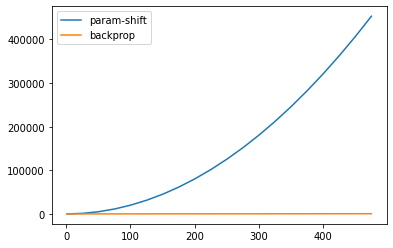

In [ ]:
import matplotlib.pyplot as plt

# note: this function implicitly assumes
# single-batch training
def num_evals(n_params, n_steps):
    return 2*n_params*n_steps

x_axis = range(1, 500, 25)
scaling = [num_evals(i, i) for i in x_axis]

plt.plot(x_axis, scaling, label="param-shift")
plt.plot(x_axis, [x for x in x_axis], label="backprop")
plt.legend()